In [1]:
import numpy as np
from six.moves import cPickle
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
reps = 20 # number of times the EM algorithm is run for every value of K
Ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # number of mixture elements to be considered
d = 10 # dimension of each mixture component
N_samples = 10000 # number of samples used taken from the mixture
EM_max_iter = 1000 # maximum number of iterations for EM
EM_tol = 1e-8 # EM stops once the estimates change by less than this
N_kl = 1000 # number of samples used to compute the KL


In [3]:
# HELPER FUNCTIONS FOR CONTINUOUS BERNOULLI EM
def mean_from_lam(lam):
    # given a numpy array of lambda parameters of a continuous Bernoulli, returns the corresponding means.
    # this is inefficient as it is not vectorized, but this is only run once to a get a vectorized approximation
    # to its inverse
    lam_shape = np.shape(lam)
    reshaped_lam = np.reshape(lam, -1)
    means = np.zeros_like(reshaped_lam)
    for i in xrange(len(reshaped_lam)):
        if reshaped_lam[i]>=1:
            means[i] = reshaped_lam[i]
        elif reshaped_lam[i]==0.5:
            means[i] = 0.5
        elif reshaped_lam[i]>0:
            means[i] = reshaped_lam[i] / (2.0 * reshaped_lam[i] - 1.0) + 1.0 / (2.0 * np.arctanh(1.0 - 2.0 *
                                                                                                 reshaped_lam[i]))
        else:
            means[i] = reshaped_lam[i]
    means = np.reshape(means, lam_shape)
    return means

xs = np.linspace(0.0, 1.0 + 1e-4, 100)
ys = mean_from_lam(xs)
def cont_bern_lam(mu, knots=np.array(xs, dtype='float32'), vals_at_knots=np.array(ys, dtype='float32')):
    # given the mean parameter mu of a continuous Bernoulli distribution, returns the canonical parameter lambda.
    # vectorized version of the inverse of the previous function
    # note that it returs the incorrect value at mu=1.0
    slopes = (vals_at_knots[1:] - vals_at_knots[:-1]) / (knots[1:] - knots[:-1])
    intercepts = vals_at_knots[1:] - slopes * knots[1:]
    inv_slopes = 1.0 / slopes
    inv_intercepts = - intercepts / slopes

    dims = np.shape(mu)
    reshaped_mu = np.reshape(mu, [-1])  # [?]
    diff_1 = np.expand_dims(reshaped_mu, 1) - np.expand_dims(vals_at_knots[:-1], 0)  # [?, n_knots-1]
    diff_2 = np.expand_dims(vals_at_knots[1:], 0) - np.expand_dims(reshaped_mu, 1)  # [?, n_knots-1]
    masks = np.where(np.logical_and(np.greater_equal(diff_1, 0.0), np.greater(diff_2, 0.0)),
                     np.ones([np.shape(reshaped_mu)[0], np.shape(vals_at_knots)[0] - 1]),
                     np.zeros([np.shape(reshaped_mu)[0], np.shape(vals_at_knots)[0] - 1]))  # [?, n_knots-1]
    all_lines = np.expand_dims(reshaped_mu, 1) * np.expand_dims(inv_slopes, 0) + np.expand_dims(inv_intercepts, 0)
    all_lines = masks * all_lines
    reshaped_lam = np.sum(all_lines, 1)
    lam = np.reshape(reshaped_lam, dims)
    return lam

def sample_cont_bern(lam):
    u = np.random.uniform(0, 1, np.shape(lam))
    samples = np.where(np.logical_and(lam > 0.499, lam < 0.501), u,
                       (np.log(u * (2.0 * lam - 1.0) + 1.0 - lam) - np.log(1.0 - lam)) / (np.log(lam) - np.log(1.0 - lam)))
    return samples

def sample_cont_bern_mix(n_samples, c, lam):
    K, d = np.shape(lam)
    samples = np.zeros([n_samples, d])
    for i in xrange(n_samples):
        mix_comp = np.random.choice(np.arange(K), p=c)
        samples[i] = sample_cont_bern(lam[mix_comp])
    return samples

In [4]:
# EM ALGORITHM FUNCTIONS FOR MIXTURE OF CONTINUOUS BERNOULLIS
def cb_log_lik(x, lam, cheat=False):
    #given x [N, d] and lam [K, d], gives back the log likelihood of a d-dimensional continuous Bernoulli distribution
    # with parameter lam for each of the N x's and the K lam's (output has shape [N, K])
    reshaped_x = np.expand_dims(x, 1) # [N, 1, d]
    reshaped_lam = np.expand_dims(lam, 0) # [1, K, d]
    bern_log_lik = reshaped_x * np.log(reshaped_lam) + (1.0 - reshaped_x) * np.log(1.0 - reshaped_lam) # [N, K, d]
    extra = 0.0
    if not cheat:
        cut_lam = np.where(np.logical_or(lam < 0.49, lam > 0.51), lam, 0.49 * np.ones_like(lam))
        log_norm = np.log(np.absolute(2.0 * np.arctanh(1.0 - 2.0 * cut_lam))) - np.log(np.absolute(1.0 - 2.0 * cut_lam))
        taylor = 4.0 / 3.0 * (lam - 0.5)**2 + 104.0 / 45.0 * (lam - 0.5)**4
        extra = np.expand_dims(np.where(np.logical_or(lam < 0.49, lam > 0.51), log_norm, taylor), 0)  # [N, K, d]
    log_lik = bern_log_lik + extra
    return np.sum(log_lik, axis=2)

def kl_cb_mix(n, lam1, c1, lam2, c2):
    # estimates the KL divergence between a mixture of CBs with lambdas lam1 [K, d] and mixture weights c1 [K] and
    # a mixture of CBs with lambdas lam2 and mixture weights c2.
    # samples n times from the first mixture to estimate this
    x1 = sample_cont_bern_mix(n, c1, lam1)
    log_p_1 = np.mean(np.log(np.sum(np.exp(cb_log_lik(x1, lam1)) * np.expand_dims(c1, 0), 1)))
    log_p_2 = np.mean(np.log(np.sum(np.exp(cb_log_lik(x1, lam2)) * np.expand_dims(c2, 0), 1)))
    return log_p_1 - log_p_2


def cb_em_step(c, lam, x, cheat=False):
    # given current estimates of c [K] and lam [K, d] of a d-dimensional mixture of continuous Bernoulli distributions
    # and data [N, d] (N samples of d-dimensions), returns the next estimates after applying one iteration of the EM
    # algorithm
    logCBs = cb_log_lik(x, lam, cheat) # [N, K]
    Ts = np.expand_dims(c, 0) * np.exp(logCBs) # [N, K]
    Ts = Ts / np.sum(Ts, axis=1, keepdims=True) # [N, K]
    new_c = np.mean(Ts, axis=0)
    reweighted_Ts = Ts / np.sum(Ts, axis=0, keepdims=True)
    new_lam = np.sum(np.expand_dims(reweighted_Ts, 2) * np.expand_dims(x, 1), 0) #[K, d]
    if not cheat:
        new_lam = cont_bern_lam(new_lam)
    return new_c, new_lam

def cb_em_alg(x, K, tol, max_iter, cheat=False):
    d = np.shape(x)[1]
    lam = np.random.uniform(1e-4, 1-1e-4, size=(K, d))
    c = np.ones(K) / K
    reach_max_iter = True
    for i in xrange(max_iter):
        new_c, new_lam = cb_em_step(c, lam, x, cheat)
        if np.maximum(np.max(new_c - c), np.max(new_lam - lam)) < tol:
            c = new_c
            lam = new_lam
            reach_max_iter = False
            break
        c = new_c
        lam = new_lam
    return c, lam, reach_max_iter


In [5]:
#SIMPLE CHECK
c_test = np.array([0.4, 0.6])
lam_test = np.array([[0.1, 0.8], [0.7, 0.3]])
data = sample_cont_bern_mix(10000, c_test, lam_test)
c_est, lam_est, _ = cb_em_alg(data, len(c_test), 1e-32, 1000)
print c_est
print lam_est

[0.37679623 0.62320377]
[[0.0757225  0.80279264]
 [0.70631627 0.32681622]]
------------
0.0


In [6]:
#FOR EACH K IN Ks, GENERATE DATA AND RUN EM, BOTH CHEATING AND NOT. REPEAT REPS TIMES.
num_Ks = len(Ks)
kls = np.zeros([reps, num_Ks])
kls_cheat = np.zeros([reps, num_Ks])
kls_cheat_muinv = np.zeros([reps, num_Ks])

for rep in xrange(reps):
    print('repetition: ' + str(rep))
    for k in xrange(num_Ks):
        true_lams = np.random.uniform(size=[Ks[k], d])
        data = sample_cont_bern_mix(N_samples, np.ones(Ks[k]) / Ks[k], true_lams)
        est_c, est_lam, _ = cb_em_alg(data, Ks[k], EM_tol, EM_max_iter)
        est_c_cheat, est_lam_cheat, _ = cb_em_alg(data, Ks[k], EM_tol, EM_max_iter, True)
        est_lam_muinv_cheat = cont_bern_lam(est_lam_cheat)
        kls[rep, k] = kl_cb_mix(N_kl, true_lams, np.ones(Ks[k]) / Ks[k], est_lam, est_c)
        kls_cheat[rep, k] = kl_cb_mix(N_kl, true_lams, np.ones(Ks[k]) / Ks[k], est_lam_cheat, est_c_cheat)
        kls_cheat_muinv[rep, k] = kl_cb_mix(N_kl, true_lams, np.ones(Ks[k]) / Ks[k], est_lam_muinv_cheat, est_c_cheat)


repetition: 0
repetition: 1
repetition: 2
repetition: 3
repetition: 4
repetition: 5
repetition: 6
repetition: 7
repetition: 8
repetition: 9
repetition: 10
repetition: 11
repetition: 12
repetition: 13
repetition: 14
repetition: 15
repetition: 16
repetition: 17
repetition: 18
repetition: 19


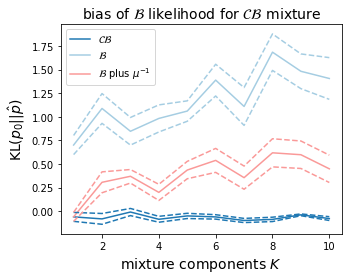

In [12]:
blue1 = (166.0 / 256.0, 206.0 / 256.0, 227.0 / 256.0)
blue2 = (31.0 / 256.0, 120.0 / 256.0, 180.0 / 256.0)
red1 = (251.0 / 256.0, 154.0 / 256.0, 153.0 / 256.0)

plt.figure(figsize=(5, 4))
plt.plot(np.array(Ks), np.mean(kls, axis=0), label=r"$\mathcal{CB}$", color=blue2)
plt.plot(np.array(Ks), np.mean(kls_cheat, axis=0), label=r"$\mathcal{B}$", color=blue1)
plt.plot(np.array(Ks), np.mean(kls_cheat_muinv, axis=0), label=r"$\mathcal{B}$ plus $\mu^{-1}$", color=red1)

plt.plot(np.array(Ks), np.mean(kls, axis=0) - np.std(kls, axis=0) / np.sqrt(reps), color=blue2, ls='--')
plt.plot(np.array(Ks), np.mean(kls, axis=0) + np.std(kls, axis=0) / np.sqrt(reps), color=blue2, ls='--')
plt.plot(np.array(Ks), np.mean(kls_cheat, axis=0) - np.std(kls_cheat, axis=0) / np.sqrt(reps), color=blue1, ls='--')
plt.plot(np.array(Ks), np.mean(kls_cheat, axis=0) + np.std(kls_cheat, axis=0) / np.sqrt(reps), color=blue1, ls='--')
plt.plot(np.array(Ks), np.mean(kls_cheat_muinv, axis=0) - np.std(kls_cheat_muinv, axis=0) / np.sqrt(reps), color=red1, ls='--')
plt.plot(np.array(Ks), np.mean(kls_cheat_muinv, axis=0) + np.std(kls_cheat_muinv, axis=0) / np.sqrt(reps), color=red1, ls='--')

plt.xlabel(r"mixture components $K$", fontsize=14)
plt.ylabel(r"KL$(p_0|| \hat{p})$", fontsize=14)
plt.legend()
plt.title(r"bias of $\mathcal{B}$ likelihood for $\mathcal{CB}$ mixture", fontsize=14)
plt.tight_layout()
# plt.savefig('cont_bern_em_mix.pdf', bbox_inches="tight")